In [1]:
from pyspark.sql import SparkSession

# Iniciar a sessão Spark
# Definir um tamanho máximo de memória disponível para uso pelo driver
spark = SparkSession.builder \
    .appName("Bolsa Familia Data Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Definir o caminho do arquivo CSV
csv_file_path = 'BolsaFamilia/202306_NovoBolsaFamilia.csv'

# Ler os dados do CSV para um DataFrame. Aqui, assumimos que o arquivo CSV possui um cabeçalho.
# Também inferimos automaticamente o esquema dos dados. Adicionalmente, como o delimitador
# padrão de um arquivo CSV é uma vírgula e o arquivo que estamos usando pode ter um delimitador diferente
# (como ponto e vírgula), especificamos isso na opção 'sep'. Também indicamos o caractere de aspas
# com a opção 'quote'. Para lidar com questões de codificação de caracteres que podem surgir ao trabalhar
# com arquivos em formatos diferentes de UTF-8, usamos a opção 'encoding' para definir a codificação
# correta, que neste caso é 'ISO-8859-1'.
bolsa_familia_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("encoding", "ISO-8859-1") \
    .option("sep", ";") \
    .option("quote", "\"") \
    .csv(csv_file_path)

# Mostrar as primeiras linhas do DataFrame para verificação. Aqui, usamos 'truncate=False' para garantir
# que o Spark exiba o conteúdo completo das células do DataFrame, o que é útil para visualizar dados
# com conteúdo mais extenso.
bolsa_familia_df.show(truncate=False)

+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|MÊS COMPETÊNCIA|MÊS REFERÊNCIA|UF |CÓDIGO MUNICÍPIO SIAFI|NOME MUNICÍPIO|CPF FAVORECIDO|NIS FAVORECIDO|NOME FAVORECIDO                |VALOR PARCELA|
+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|202306         |202306        |AC |643                   |ACRELANDIA    |***.833.642-**|16167611395   |ABIGAIL DAGMAR MACHADO         |850,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |null          |16122034321   |ABRAAO AMORA SALGUEIRO         |600,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.355.042-**|16121660806   |ABRAAO DA PIEDADE DO NASCIMENTO|750,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.050.782-**|16094

In [2]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.types import FloatType

# Renomear colunas para eliminar espaços e padronizar a nomenclatura
renamed_df = bolsa_familia_df.select(
    col("MÊS COMPETÊNCIA").alias("mes_competencia"),
    col("MÊS REFERÊNCIA").alias("mes_referencia"),
    col("UF"),
    col("CÓDIGO MUNICÍPIO SIAFI").alias("codigo_municipio_siafi"),
    col("NOME MUNICÍPIO").alias("nome_municipio"),
    col("CPF FAVORECIDO").alias("cpf_favorecido"),
    col("NIS FAVORECIDO").alias("nis_favorecido"),
    col("NOME FAVORECIDO").alias("nome_favorecido"),
    regexp_replace(col("VALOR PARCELA"), ",", ".").alias("valor_parcela").cast(FloatType())
)

# Tratamento de valores nulos
# Aqui optamos por manter as linhas com CPF nulo, mas você pode decidir remover ou tratar de forma diferente
cleaned_df = renamed_df.fillna({'cpf_favorecido': 'Não informado'})

# Ajustar tipo de dados para números onde aplicável
# Neste caso, o NIS já está sendo tratado como string, o que é adequado dado que é um identificador

# Mostrar as primeiras linhas do DataFrame limpo para verificação
cleaned_df.show(truncate=False)


+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|mes_competencia|mes_referencia|UF |codigo_municipio_siafi|nome_municipio|cpf_favorecido|nis_favorecido|nome_favorecido                |valor_parcela|
+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|202306         |202306        |AC |643                   |ACRELANDIA    |***.833.642-**|16167611395   |ABIGAIL DAGMAR MACHADO         |850.0        |
|202306         |202306        |AC |643                   |ACRELANDIA    |Não informado |16122034321   |ABRAAO AMORA SALGUEIRO         |600.0        |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.355.042-**|16121660806   |ABRAAO DA PIEDADE DO NASCIMENTO|750.0        |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.050.782-**|16094

In [3]:
# Contagem total de registros antes da filtragem
total_before = cleaned_df.count()
print(f"Total de registros antes da filtragem: {total_before}")

# Filtrando registros com base em condições
cleaned_df = cleaned_df.filter(cleaned_df["valor_parcela"] > 0)

# Contagem total de registros depois da filtragem
total_after = cleaned_df.count()
print(f"Total de registros após a filtragem: {total_after}")


Total de registros antes da filtragem: 20303520
Total de registros após a filtragem: 20303520


In [4]:
# Contagem total de registros antes da remoção de duplicatas
total_before_dedup = cleaned_df.count()
print(f"Total de registros antes da remoção de duplicatas: {total_before_dedup}")

# Removendo duplicatas
cleaned_df = cleaned_df.dropDuplicates()

# Contagem total de registros depois da remoção de duplicatas
total_after_dedup = cleaned_df.count()
print(f"Total de registros após a remoção de duplicatas: {total_after_dedup}")

# Calculando e exibindo o número de registros duplicados removidos
duplicates_removed = total_before_dedup - total_after_dedup
print(f"Número de registros duplicados removidos: {duplicates_removed}")


Total de registros antes da remoção de duplicatas: 20303520
Total de registros após a remoção de duplicatas: 20303490
Número de registros duplicados removidos: 30


In [5]:
from pyspark.sql import functions as F

# Supondo que a coluna "Ano/Mes Referencia" está no formato 'yyyyMM'
cleaned_df = cleaned_df.withColumn("Ano_Referencia", F.year(F.to_date(cleaned_df["mes_referencia"], "yyyyMM")))
cleaned_df = cleaned_df.withColumn("Mes_Referencia", F.month(F.to_date(cleaned_df["mes_referencia"], "yyyyMM")))

In [6]:
# Supondo que temos uma coluna "Data" no formato 'yyyy-MM-dd'
# cleaned_df = cleaned_df.withColumn("Dia", F.dayofmonth(F.to_date(cleaned_df["Data"], "yyyy-MM-dd")))

In [7]:
cleaned_df.show()

+---------------+--------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+--------------+
|mes_competencia|Mes_Referencia| UF|codigo_municipio_siafi|      nome_municipio|cpf_favorecido|nis_favorecido|     nome_favorecido|valor_parcela|Ano_Referencia|
+---------------+--------------+---+----------------------+--------------------+--------------+--------------+--------------------+-------------+--------------+
|         202306|             6| AM|                   255|              MANAUS|***.512.882-**|   23876614348|EDINELZA MARTINS ...|        180.0|          2023|
|         202306|             6| AC|                   105|           BRASILEIA|***.734.862-**|   16036979380|ANA PAULA CAVALCA...|        205.0|          2023|
|         202306|             6| AL|                  2731|              CANAPI|***.078.204-**|   16369583546|MARIA DE FATIMA L...|        205.0|          2023|
|         202306|             6| A

In [8]:
# Suponha que você queira exibir apenas algumas colunas específicas, como "Ano_Referencia", "Mes_Referencia" e "valor_parcela"
selected_columns_df = cleaned_df.select("Ano_Referencia", "Mes_Referencia", "valor_parcela")

# Agora, exiba as primeiras linhas do DataFrame com essas colunas selecionadas
selected_columns_df.show(truncate=False)

+--------------+--------------+-------------+
|Ano_Referencia|Mes_Referencia|valor_parcela|
+--------------+--------------+-------------+
|2023          |6             |180.0        |
|2023          |6             |205.0        |
|2023          |6             |205.0        |
|2023          |6             |205.0        |
|2023          |6             |205.0        |
|2023          |6             |205.0        |
|2023          |6             |230.0        |
|2023          |6             |230.0        |
|2023          |6             |230.0        |
|2023          |6             |230.0        |
|2023          |6             |230.0        |
|2023          |6             |255.0        |
|2023          |6             |255.0        |
|2023          |6             |255.0        |
|2023          |6             |255.0        |
|2023          |6             |255.0        |
|2023          |6             |255.0        |
|2023          |6             |280.0        |
|2023          |6             |300

In [9]:
# Filtrando registros onde o CPF do beneficiário segue um padrão de 11 dígitos
# cleaned_df = cleaned_df.filter(cleaned_df["CPF_Beneficiario"].rlike("^\d{11}$"))

# Filtrando registros que contêm um nome específico de favorecido
# cleaned_df = cleaned_df.filter(cleaned_df["Nome_Favorecido"].rlike("Nome Específico"))

# Filtrando registros que correspondem a um nome de município específico
# cleaned_df = cleaned_df.filter(cleaned_df["Nome_Municipio"].rlike("Nome do Município"))


In [11]:
# Calculando estatísticas descritivas para a coluna de valor das parcelas
cleaned_df.describe("valor_parcela").show()


+-------+-----------------+
|summary|    valor_parcela|
+-------+-----------------+
|  count|         20303490|
|   mean|683.0543957713674|
| stddev|166.6037891561496|
|    min|             25.0|
|    max|           4514.0|
+-------+-----------------+



In [12]:
# Soma total de pagamentos por UF
cleaned_df.groupBy("UF").sum("valor_parcela").show()

+---+------------------+
| UF|sum(valor_parcela)|
+---+------------------+
| SC|      1.48329545E8|
| RO|       8.4808353E7|
| PI|      4.08516567E8|
| AM|      4.49869692E8|
| RR|       4.8763451E7|
| GO|      3.29398276E8|
| TO|       1.0723243E8|
| MT|      1.72388722E8|
| SP|     1.681907945E9|
| ES|      1.99195634E8|
| PB|      4.49283008E8|
| RS|      3.90795806E8|
| MS|      1.38073872E8|
| AL|      3.61330074E8|
| MG|     1.052019277E9|
| PA|      9.13096805E8|
| BA|     1.648606874E9|
| SE|      2.56898968E8|
| PE|     1.070949406E9|
| CE|      9.67900457E8|
+---+------------------+
only showing top 20 rows



In [13]:
# Média de valor de parcela por município
cleaned_df.groupBy("Nome_Municipio").avg("valor_parcela").show()

+--------------------+------------------+
|      Nome_Municipio|avg(valor_parcela)|
+--------------------+------------------+
|     CRUZEIRO DO SUL| 746.1043527178117|
|  SAO JOAO DE MERITI| 668.0002600104004|
|           ITAPARICA| 653.1520905255082|
| TEIXEIRA DE FREITAS|  674.061882437793|
|            LINHARES|  695.315540911587|
|ALTO ALEGRE DO MA...| 701.7597803706245|
|          ACAILANDIA|  706.977630957999|
|             ARACUAI| 671.1283815851922|
| CARMOPOLIS DE MINAS| 696.1376564277588|
|       FOZ DO IGUACU| 694.2448439450686|
|          BATAGUASSU| 692.6650746268657|
|          GUZOLANDIA| 674.8106995884774|
|      TOBIAS BARRETO| 651.0049138247158|
|         PORTO FELIZ| 691.0682610861983|
|  ESTRELA DE ALAGOAS| 690.1504651908887|
|    CURRAL DE DENTRO|  681.507769145394|
|            ALTEROSA| 696.5696682464455|
|          SAO RAFAEL| 635.5149325626204|
|               CANAS|            682.65|
|           IBIRACATU| 704.6643286573146|
+--------------------+------------

In [14]:
# Filtrando os dados para a UF de Bahia (BA)
df_ba = cleaned_df.filter(cleaned_df["UF"] == "BA")

# Agrupando por município e calculando a média do valor das parcelas
media_por_municipio_ba = df_ba.groupBy("Nome_Municipio").avg("valor_parcela")

# Exibindo os resultados
media_por_municipio_ba.show(truncate=False)

+----------------------+------------------+
|Nome_Municipio        |avg(valor_parcela)|
+----------------------+------------------+
|ITAPARICA             |653.1520905255082 |
|TEIXEIRA DE FREITAS   |674.061882437793  |
|RIBEIRA DO POMBAL     |679.5988560059686 |
|ITARANTIM             |662.2887573964497 |
|RIACHAO DO JACUIPE    |647.2095209217707 |
|ABARE                 |678.9279420403368 |
|OLIVEIRA DOS BREJINHOS|681.2926157697121 |
|RIO REAL              |676.053283925377  |
|ANDORINHA             |649.9588647959183 |
|CURACA                |671.726731937043  |
|RETIROLANDIA          |662.9710601719198 |
|WAGNER                |675.3935799023029 |
|SANTO ESTEVAO         |677.5146153846154 |
|CANUDOS               |676.2589013224822 |
|CRAVOLANDIA           |677.0132211538462 |
|CATURAMA              |690.3087301587302 |
|CONCEICAO DA FEIRA    |639.9761348897536 |
|CORIBE                |668.0590846047156 |
|ITAJU DO COLONIA      |682.177151120752  |
|LAFAIETE COUTINHO     |663.2139

In [ ]:
# Filtrando os dados para a UF da Bahia (BA) e agrupando por município para calcular a média do valor das parcelas
media_por_municipio_ba = (cleaned_df
                          .filter(cleaned_df["UF"] == "BA")
                          .groupBy("Nome_Municipio")
                          .avg("valor_parcela"))

# Exibindo os resultados com largura de coluna ajustada
media_por_municipio_ba.show(truncate=False)

In [15]:
# Contagem de beneficiários por município
cleaned_df.groupBy("Nome_Municipio").count().show()

+--------------------+-----+
|      Nome_Municipio|count|
+--------------------+-----+
|  SAO JOAO DE MERITI|38460|
|           ITAPARICA| 5214|
| TEIXEIRA DE FREITAS|13865|
|            LINHARES| 9105|
|ALTO ALEGRE DO MA...| 4371|
|          ACAILANDIA|10595|
|             ARACUAI| 4214|
| CARMOPOLIS DE MINAS|  879|
|       FOZ DO IGUACU|20025|
|          BATAGUASSU| 1675|
|          GUZOLANDIA|  243|
|      TOBIAS BARRETO|13635|
|     CRUZEIRO DO SUL|14221|
|  ESTRELA DE ALAGOAS| 3117|
|         PORTO FELIZ| 2007|
|    CURRAL DE DENTRO| 1802|
|            ALTEROSA| 1055|
|          SAO RAFAEL| 2076|
|               CANAS|  580|
|             BRUSQUE| 2825|
+--------------------+-----+
only showing top 20 rows



In [16]:
# Soma total de pagamentos por mês
cleaned_df.groupBy("Mes_Referencia").sum("valor_parcela").orderBy("Mes_Referencia").show()

+--------------+------------------+
|Mes_Referencia|sum(valor_parcela)|
+--------------+------------------+
|             6|   1.3868388094E10|
+--------------+------------------+



In [26]:
from pyspark.sql import functions as F

# Calculando a soma total de pagamentos por mês
soma_por_mes = cleaned_df.groupBy("Mes_Referencia").sum("valor_parcela").orderBy("Mes_Referencia")

# Formatando a coluna da soma e renomeando para "Total_Pagamentos"
soma_por_mes = soma_por_mes.withColumn("Total_Pagamentos", 
                                       F.format_number(F.col("sum(valor_parcela)"), 2))

# Exibindo os resultados com a coluna renomeada
soma_por_mes.select("Mes_Referencia", "Total_Pagamentos").show(truncate=False)


+--------------+-----------------+
|Mes_Referencia|Total_Pagamentos |
+--------------+-----------------+
|6             |13,868,388,094.00|
+--------------+-----------------+



In [28]:
soma_por_mes.printSchema()

root
 |-- Mes_Referencia: integer (nullable = true)
 |-- sum(valor_parcela): double (nullable = true)
 |-- Total_Pagamentos: string (nullable = true)



In [29]:
# Histograma dos valores das parcelas (pode ser integrado com Matplotlib ou Seaborn)
valores_parcelas = cleaned_df.select("valor_parcela").rdd.flatMap(lambda x: x).collect()
# Aqui, você pode usar Matplotlib ou Seaborn para plotar o histograma

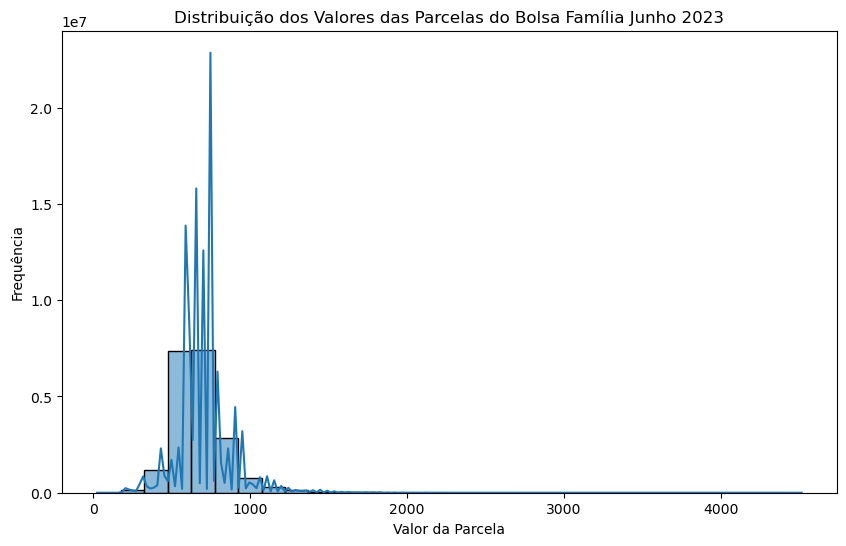

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exemplo: Histograma dos valores das parcelas
plt.figure(figsize=(10, 6))
sns.histplot(valores_parcelas, bins=30, kde=True)
plt.title('Distribuição dos Valores das Parcelas do Bolsa Família Junho 2023')
plt.xlabel('Valor da Parcela')
plt.ylabel('Frequência')
plt.show()

## Exercícios para Praticar

### Vou recriar o dataframe para utilizar nos exercícios

In [1]:
from pyspark.sql import SparkSession

# Iniciar a sessão Spark
# Definir um tamanho máximo de memória disponível para uso pelo driver
spark = SparkSession.builder \
    .appName("Bolsa Familia Data Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Definir o caminho do arquivo CSV
csv_file_path = 'BolsaFamilia/202306_NovoBolsaFamilia.csv'

# Ler os dados do CSV para um DataFrame. Aqui, assumimos que o arquivo CSV possui um cabeçalho.
# Também inferimos automaticamente o esquema dos dados. Adicionalmente, como o delimitador
# padrão de um arquivo CSV é uma vírgula e o arquivo que estamos usando pode ter um delimitador diferente
# (como ponto e vírgula), especificamos isso na opção 'sep'. Também indicamos o caractere de aspas
# com a opção 'quote'. Para lidar com questões de codificação de caracteres que podem surgir ao trabalhar
# com arquivos em formatos diferentes de UTF-8, usamos a opção 'encoding' para definir a codificação
# correta, que neste caso é 'ISO-8859-1'.
bolsa_familia_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("encoding", "ISO-8859-1") \
    .option("sep", ";") \
    .option("quote", "\"") \
    .csv(csv_file_path)

# Mostrar as primeiras linhas do DataFrame para verificação. Aqui, usamos 'truncate=False' para garantir
# que o Spark exiba o conteúdo completo das células do DataFrame, o que é útil para visualizar dados
# com conteúdo mais extenso.
bolsa_familia_df.show(truncate=False)

+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|MÊS COMPETÊNCIA|MÊS REFERÊNCIA|UF |CÓDIGO MUNICÍPIO SIAFI|NOME MUNICÍPIO|CPF FAVORECIDO|NIS FAVORECIDO|NOME FAVORECIDO                |VALOR PARCELA|
+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|202306         |202306        |AC |643                   |ACRELANDIA    |***.833.642-**|16167611395   |ABIGAIL DAGMAR MACHADO         |850,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |null          |16122034321   |ABRAAO AMORA SALGUEIRO         |600,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.355.042-**|16121660806   |ABRAAO DA PIEDADE DO NASCIMENTO|750,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.050.782-**|16094

In [32]:
# Transformando a coluna de nomes dos beneficiários em um RDD
nomes_beneficiarios_rdd = bolsa_familia_df.select("NOME FAVORECIDO").rdd.flatMap(lambda row: row)

# Aplicando função lambda para extrair as iniciais
iniciais_rdd = nomes_beneficiarios_rdd.map(lambda nome: ''.join([x[0].upper() for x in nome.split()]))

# Coletando e exibindo as iniciais
print(iniciais_rdd.take(10))

['ADM', 'AAS', 'ADPDN', 'AKR', 'AMSA', 'ABDA', 'ANDS', 'ADSP', 'AIDM', 'ADSC']


In [46]:
from pyspark.sql.functions import col

# Filtrando o DataFrame para manter somente os registros do ano corrente (2023)
pagamentos_2023_df = bolsa_familia_df.filter(col("MÊS COMPETÊNCIA").cast("string").substr(1, 4) == "2023")

# Exibindo os registros filtrados
pagamentos_2023_df.show(truncate=False)

+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|MÊS COMPETÊNCIA|MÊS REFERÊNCIA|UF |CÓDIGO MUNICÍPIO SIAFI|NOME MUNICÍPIO|CPF FAVORECIDO|NIS FAVORECIDO|NOME FAVORECIDO                |VALOR PARCELA|
+---------------+--------------+---+----------------------+--------------+--------------+--------------+-------------------------------+-------------+
|202306         |202306        |AC |643                   |ACRELANDIA    |***.833.642-**|16167611395   |ABIGAIL DAGMAR MACHADO         |850,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |null          |16122034321   |ABRAAO AMORA SALGUEIRO         |600,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.355.042-**|16121660806   |ABRAAO DA PIEDADE DO NASCIMENTO|750,00       |
|202306         |202306        |AC |643                   |ACRELANDIA    |***.050.782-**|16094

In [49]:
from pyspark.sql.functions import col, regexp_replace

# Primeiro, convertendo a coluna "VALOR PARCELA" para string
bolsa_familia_df = bolsa_familia_df.withColumn("valor_str", col("VALOR PARCELA").cast("string"))

# Agora, substituindo vírgula por ponto e convertendo para float
bolsa_familia_df = bolsa_familia_df.withColumn("VALOR_PARCELA_FLOAT", 
                                                regexp_replace("valor_str", ",", ".").cast("float"))

# Removendo a coluna intermediária "valor_str" para limpeza
bolsa_familia_df = bolsa_familia_df.drop("valor_str")

# Transformando a coluna de valores das parcelas em um RDD
valores_parcela_rdd = bolsa_familia_df.select("VALOR_PARCELA_FLOAT").rdd.flatMap(lambda row: row)

# Função lambda para arredondar os valores
arredondados_rdd = valores_parcela_rdd.map(lambda valor: round(valor))

# Coletando e exibindo os valores arredondados
print(arredondados_rdd.take(10))


[850, 600, 750, 600, 700, 650, 600, 600, 600, 650]
